## Siemens PCA and FPCA as outlier detector

This code shows the implementation of PCA and FPCA for reducing the dimension of the multiple time series.
It adds the scores and identify the time series which contribute the most to the principal components. 
However, after some research the main benefit of this technique relies on 2D visualization and outlier detection due to its sensibility to campture patterns in the data.

For instance, if commenting the block of code "Data cleaning - Removing unsuccessful return codes" and runing PCA and FPCA on "A1_cal_window" we can observe how the second component displays a peak. However, when removing the unsuccessful return codes as was suggested by Siemens in the meeting of May 17th, we can see this pattern dissapears. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

In [3]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [4]:
# Merge dataset with keyByTestID and delete unmatched tests
# Sensor A
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]

# Merge dataset with keyByTestID
# Sensor B
B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B2_transposed = B2_transposed[B2_transposed['TestID'].isin(B2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3407, 2694)
A2:  (7781, 1319)
B1:  (3398, 3376)
B2:  (7780, 3367)


## Identifying TestID with bad return codes

In [5]:
A1_Merged_bad_returncodes = A1_Merged[~A1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
A2_Merged_bad_returncodes = A2_Merged[~A2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B1_Merged_bad_returncodes = B1_Merged[~B1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B2_Merged_bad_returncodes = B2_Merged[~B2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()

print('A1_Merged_bad_returncodes')
print(A1_Merged_bad_returncodes['TestID'])
print('\nA2_Merged_bad_returncodes\n')
print(A2_Merged_bad_returncodes['TestID'])
print('\nB1_Merged_bad_returncodes\n')
print(B1_Merged_bad_returncodes['TestID'])
print('\nB2_Merged_bad_returncodes\n')
print(B2_Merged_bad_returncodes['TestID'])

A1_Merged_bad_returncodes
0       12414199
44      12416289
48      12416278
122     12446029
201     12486850
492     12601278
728     12191442
995     12514810
1051    12515535
1091    12515705
1205    12480292
1207    12623120
1242    12597803
1355    12530207
1602    12530199
1915    12472338
2060    12530446
2071    12530379
2261    12557613
2301    12470796
2352    12529229
2374    12390613
2652    12371902
2826    12529328
3095    12531249
Name: TestID, dtype: int64

A2_Merged_bad_returncodes

608     3561473
859     3545381
1085    3547411
1258    3548457
1698    3553569
1728    3553619
1983    3555557
2258    3557972
2497    3561799
2688    3564315
2877    3565626
2889    3565643
2924    3565699
2944    3565740
3009    3565982
3039    3566065
3046    3566584
3072    3566624
3115    3566834
3117    3566837
3118    3566838
3171    3566963
3806    3552740
3921    3552653
4039    3569098
5523    3555888
5577    3555913
5608    3558047
6242    3558380
6950    3567852
7145    355160

## Data cleaning - Removing unsuccessful return codes

In [6]:
#A1_Merged = A1_Merged[A1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
#A2_Merged = A2_Merged[A2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
#B1_Merged = B1_Merged[B1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
#B2_Merged = B2_Merged[B2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()

#A1_Merged.reset_index(drop=True, inplace=True)
#A2_Merged.reset_index(drop=True, inplace=True)
#B1_Merged.reset_index(drop=True, inplace=True)
#B2_Merged.reset_index(drop=True, inplace=True)

#print('A1: ', A1_Merged.shape)
#print('A2: ', A2_Merged.shape)
#print('B1: ', B1_Merged.shape)
#print('B2: ', B2_Merged.shape)

## Filtering and spliting in Blood and Aquous groups

In [7]:
# Blood
A1_blood_Merged = A1_Merged[A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_blood_Merged = A2_Merged[A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_blood_Merged.reset_index(drop=True, inplace=True)
A2_blood_Merged.reset_index(drop=True, inplace=True)

# Aquous
A1_aquous_Merged = A1_Merged[~A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_aquous_Merged = A2_Merged[~A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_aquous_Merged.reset_index(drop=True, inplace=True)
A2_aquous_Merged.reset_index(drop=True, inplace=True)

# Blood
B1_blood_Merged = (B1_Merged[B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_blood_Merged = (B2_Merged[B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_blood_Merged.reset_index(drop=True, inplace=True)
B2_blood_Merged.reset_index(drop=True, inplace=True)

# Aquous
B1_aquous_Merged = (B1_Merged[~B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_aquous_Merged = (B2_Merged[~B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_aquous_Merged.reset_index(drop=True, inplace=True)
B2_aquous_Merged.reset_index(drop=True, inplace=True)

## Window extraction

In [8]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Match window values of Sensor B for each test

# Blood
calDelLimit_sensorB_blood = 20
sampleDelLimit_sensorB_blood = 24
calWindowSize_sensorB_blood = 18
sampleWindowSize_sensorB_blood = 4

# Aquous
calDelLimit_sensorB_aqueous = 20
sampleDelLimit_sensorB_aqueous = 30
calWindowSize_sensorB_aqueous = 18
sampleWindowSize_sensorB_aqueous = 4

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return cal_window_start, cal_window_end, sample_window_start, sample_window_end

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# Sensor A - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_blood_Merged['cal_window_start']=cal_window_start
A1_blood_Merged['cal_window_end']=cal_window_end
A1_blood_Merged['sample_window_start']=sample_window_start
A1_blood_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_blood_Merged['cal_window_start']=cal_window_start
A2_blood_Merged['cal_window_end']=cal_window_end
A2_blood_Merged['sample_window_start']=sample_window_start
A2_blood_Merged['sample_window_end']=sample_window_end


# Sensor A - Aquous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_aquous_Merged['cal_window_start']=cal_window_start
A1_aquous_Merged['cal_window_end']=cal_window_end
A1_aquous_Merged['sample_window_start']=sample_window_start
A1_aquous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_aquous_Merged['cal_window_start']=cal_window_start
A2_aquous_Merged['cal_window_end']=cal_window_end
A2_aquous_Merged['sample_window_start']=sample_window_start
A2_aquous_Merged['sample_window_end']=sample_window_end

# Sensor B - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B1_blood_Merged['cal_window_start']=cal_window_start
B1_blood_Merged['cal_window_end']=cal_window_end
B1_blood_Merged['sample_window_start']=sample_window_start
B1_blood_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end


# Sensor B - Aquous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B1_aquous_Merged['cal_window_start']=cal_window_start
B1_aquous_Merged['cal_window_end']=cal_window_end
B1_aquous_Merged['sample_window_start']=sample_window_start
B1_aquous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B2_aquous_Merged['cal_window_start']=cal_window_start
B2_aquous_Merged['cal_window_end']=cal_window_end
B2_aquous_Merged['sample_window_start']=sample_window_start
B2_aquous_Merged['sample_window_end']=sample_window_end

In [9]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Blood

A1_blood_cal_window = []
A1_blood_sample_window = []
for i in range(len(A1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A1_blood_Merged.iloc[i, :])
    A1_blood_cal_window.append(cal_window.values)
    A1_blood_sample_window.append(sample_window.values)
A1_blood_cal_window = pd.DataFrame(A1_blood_cal_window)
A1_blood_sample_window = pd.DataFrame(A1_blood_sample_window)
A1_blood_cal_window['TestID'] = A1_blood_sample_window['TestID'] = A1_blood_Merged['TestID']
A1_blood_sample_window.set_index('TestID',inplace=True)
A1_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Aquous

A1_aquous_cal_window = []
A1_aquous_sample_window = []
for i in range(len(A1_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(A1_aquous_Merged.iloc[i, :])
    A1_aquous_cal_window.append(cal_window.values)
    A1_aquous_sample_window.append(sample_window.values)
A1_aquous_cal_window = pd.DataFrame(A1_aquous_cal_window)
A1_aquous_sample_window = pd.DataFrame(A1_aquous_sample_window)
A1_aquous_cal_window['TestID'] = A1_aquous_sample_window['TestID'] = A1_aquous_Merged['TestID']
A1_aquous_sample_window.set_index('TestID',inplace=True)
A1_aquous_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Blood

A2_blood_cal_window = []
A2_blood_sample_window = []
for i in range(len(A2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A2_blood_Merged.iloc[i, :])
    A2_blood_cal_window.append(cal_window.values)
    A2_blood_sample_window.append(sample_window.values)
A2_blood_cal_window = pd.DataFrame(A2_blood_cal_window)
A2_blood_sample_window = pd.DataFrame(A2_blood_sample_window)
A2_blood_cal_window['TestID'] = A2_blood_sample_window['TestID'] = A2_blood_Merged['TestID']
A2_blood_sample_window.set_index('TestID',inplace=True)
A2_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Aquous

A2_aquous_cal_window = []
A2_aquous_sample_window = []
for i in range(len(A2_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(A2_aquous_Merged.iloc[i, :])
    A2_aquous_cal_window.append(cal_window.values)
    A2_aquous_sample_window.append(sample_window.values)
A2_aquous_cal_window = pd.DataFrame(A2_aquous_cal_window)
A2_aquous_sample_window = pd.DataFrame(A2_aquous_sample_window)
A2_aquous_cal_window['TestID'] = A2_aquous_sample_window['TestID'] = A2_aquous_Merged['TestID']
A2_aquous_sample_window.set_index('TestID',inplace=True)
A2_aquous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Blood

B1_blood_cal_window = []
B1_blood_sample_window = []
for i in range(len(B1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B1_blood_Merged.iloc[i, :])
    B1_blood_cal_window.append(cal_window.values)
    B1_blood_sample_window.append(sample_window.values)
B1_blood_cal_window = pd.DataFrame(B1_blood_cal_window)
B1_blood_sample_window = pd.DataFrame(B1_blood_sample_window)
B1_blood_cal_window['TestID'] = B1_blood_sample_window['TestID'] = B1_blood_Merged['TestID']
B1_blood_sample_window.set_index('TestID',inplace=True)
B1_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B - Blood

B2_blood_cal_window = []
B2_blood_sample_window = []
for i in range(len(B2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B2_blood_Merged.iloc[i, :])
    B2_blood_cal_window.append(cal_window.values)
    B2_blood_sample_window.append(sample_window.values)
B2_blood_cal_window = pd.DataFrame(B2_blood_cal_window)
B2_blood_sample_window = pd.DataFrame(B2_blood_sample_window)
B2_blood_cal_window['TestID'] = B2_blood_sample_window['TestID'] = B2_blood_Merged['TestID']
B2_blood_sample_window.set_index('TestID',inplace=True)
B2_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aquous

B1_aquous_cal_window = []
B1_aquous_sample_window = []
for i in range(len(B1_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B1_aquous_Merged.iloc[i, :])
    B1_aquous_cal_window.append(cal_window.values)
    B1_aquous_sample_window.append(sample_window.values)
B1_aquous_cal_window = pd.DataFrame(B1_aquous_cal_window)
B1_aquous_sample_window = pd.DataFrame(B1_aquous_sample_window)
B1_aquous_cal_window['TestID'] = B1_aquous_sample_window['TestID'] = B1_aquous_Merged['TestID']
B1_aquous_sample_window.set_index('TestID',inplace=True)
B1_aquous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aquous

B2_aquous_cal_window = []
B2_aquous_sample_window = []
for i in range(len(B2_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B2_aquous_Merged.iloc[i, :])
    B2_aquous_cal_window.append(cal_window.values)
    B2_aquous_sample_window.append(sample_window.values)
B2_aquous_cal_window = pd.DataFrame(B2_aquous_cal_window)
B2_aquous_sample_window = pd.DataFrame(B2_aquous_sample_window)
B2_aquous_cal_window['TestID'] = B2_aquous_sample_window['TestID'] = B2_aquous_Merged['TestID']
B2_aquous_sample_window.set_index('TestID',inplace=True)
B2_aquous_cal_window.set_index('TestID',inplace=True)

## Removing partial or full series with missing values after the window extraction

In [10]:
# Drop TestId's with NA's
A1_cal_window.dropna(axis=0, inplace=True) 
A2_cal_window.dropna(axis=0, inplace=True) 

A1_blood_cal_window.dropna(axis=0, inplace=True)
A1_aquous_cal_window.dropna(axis=0, inplace=True)
A2_blood_cal_window.dropna(axis=0, inplace=True)
A2_aquous_cal_window.dropna(axis=0, inplace=True)

B1_blood_cal_window.dropna(axis=0, inplace=True)
B1_aquous_cal_window.dropna(axis=0, inplace=True)
B2_blood_cal_window.dropna(axis=0, inplace=True)
B2_aquous_cal_window.dropna(axis=0, inplace=True)

A1_sample_window.dropna(axis=0, inplace=True) 
A2_sample_window.dropna(axis=0, inplace=True) 

A1_blood_sample_window.dropna(axis=0, inplace=True)
A1_aquous_sample_window.dropna(axis=0, inplace=True)
A2_blood_sample_window.dropna(axis=0, inplace=True)
A2_aquous_sample_window.dropna(axis=0, inplace=True)

B1_blood_sample_window.dropna(axis=0, inplace=True)
B1_aquous_sample_window.dropna(axis=0, inplace=True)
B2_blood_sample_window.dropna(axis=0, inplace=True)
B2_aquous_sample_window.dropna(axis=0, inplace=True)


print('A1_cal: ', A1_cal_window.shape)
print('A2_cal: ',  A2_cal_window.shape)

print('A1_blood_cal_window: ', A1_blood_cal_window.shape)
print('A1_aquous_cal_window: ', A1_aquous_cal_window.shape)
print('A2_blood_cal_window: ', A2_blood_cal_window.shape)
print('A2_aquous_cal_window: ', A2_aquous_cal_window.shape)

print('B1_blood_cal_window: ', B1_blood_cal_window.shape)
print('B1_aquous_cal_window: ', B1_aquous_cal_window.shape)
print('B2_blood_cal_window: ', B2_blood_cal_window.shape)
print('B2_aquous_cal_window: ', B2_aquous_cal_window.shape)


print('A1_sample: ', A1_sample_window.shape)
print('A2_sample: ', A2_sample_window.shape)

print('A1_blood_sample_window: ', A1_blood_sample_window.shape)
print('A1_aquous_sample_window: ', A1_aquous_sample_window.shape)
print('A2_blood_sample_window: ', A2_blood_sample_window.shape)
print('A2_aquous_sample_window: ', A2_aquous_sample_window.shape)

print('B1_blood_sample_window: ', B1_blood_sample_window.shape)
print('B1_aquous_sample_window: ', B1_aquous_sample_window.shape)
print('B2_blood_sample_window: ', B2_blood_sample_window.shape)
print('B2_aquous_sample_window: ', B2_aquous_sample_window.shape)

A1_cal:  (3373, 41)
A2_cal:  (7591, 41)
A1_blood_cal_window:  (1925, 41)
A1_aquous_cal_window:  (1448, 41)
A2_blood_cal_window:  (4765, 41)
A2_aquous_cal_window:  (2826, 41)
B1_blood_cal_window:  (1953, 91)
B1_aquous_cal_window:  (1444, 91)
B2_blood_cal_window:  (4905, 91)
B2_aquous_cal_window:  (2869, 91)
A1_sample:  (3373, 26)
A2_sample:  (7569, 26)
A1_blood_sample_window:  (1925, 26)
A1_aquous_sample_window:  (1448, 26)
A2_blood_sample_window:  (4744, 26)
A2_aquous_sample_window:  (2825, 26)
B1_blood_sample_window:  (1953, 21)
B1_aquous_sample_window:  (1444, 21)
B2_blood_sample_window:  (4911, 21)
B2_aquous_sample_window:  (2869, 21)


## Function to plot time series in one plot

In [11]:
def plot_all_time_series(df):
    plt.figure(figsize=(6, 4))
    
    for index, row in df.iterrows():
        plt.plot(row.values, label=f'Time Series {index + 1}')

    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')

## PCA

1. Standardize the data
2. Visualize the standardize data
3. Apply PCA setting 2 PC's
4. Extract the Scores
5. Identify the Time Series which contribute most to each PC

Thanks to PCA's sensitivity, it can be used to detect outliers in multivariate datasets. Principal Component Analysis (PCA) is a widely used technique for dimensionality reduction while preserving relevant information. Due to its sensitivity, it can also be used to detect outliers in multivariate datasets.

https://s-ai-f.github.io/Time-Series/outlier-detection-in-time-series.html

In [12]:
def perform_pca_analysis(data, title):
    # Step 1: Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Visualizing scale data
    data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
    plot_all_time_series(data_scaled_df)
    plt.title(title)
    plt.show()
    
    # Step 2: Determine the number of components
    pca_full = PCA()
    pca_full.fit(data_scaled)
    print('Explained variance for each component:')
    print(pca_full.explained_variance_ratio_)
    
    # Step 3: Apply PCA on 2 components
    pca = PCA(n_components=2)
    pca_scores = pca.fit_transform(data_scaled)
    
    # Explain variance ratio
    print('\nExplain variance PC1 (%): ', pca.explained_variance_ratio_[0]*100)
    print('Explain variance PC2 (%): ', pca.explained_variance_ratio_[1]*100)
    
    # Loadings
    loadings = pca.components_
    loadings_df = pd.DataFrame(loadings.T, columns=['PC1_Loadings', 'PC2_Loadings'], index=[f'TimePoint_{i}' for i in range(data_scaled.shape[1])])
    print("\nLoadings:\n", loadings_df)
    
    # Scores
    scores_df = pd.DataFrame(pca_scores, columns=['PC1_Scores', 'PC2_Scores'], index=[f'TimeSeries_{data.index[i]}' for i in range(data_scaled.shape[0])])
    print("\nPC Scores:\n", scores_df)
    
    # Identify which time series contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pca_scores[:, 0]))
    max_contribution_index_pc2 = np.argmax(np.abs(pca_scores[:, 1]))
    print(f'\nThe time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data.index[max_contribution_index_pc2]}')
    
    # PCA visualization
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_scores[:, 0], pca_scores[:, 1], label='System 1')
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

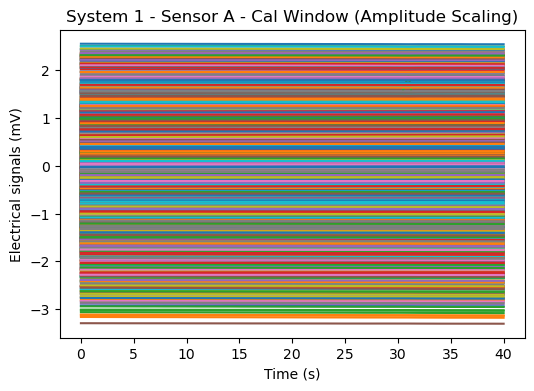

Explained variance for each component:
[9.99960199e-01 2.29378664e-05 9.21175858e-06 4.59415278e-06
 2.74618940e-06 2.79376437e-07 2.36343060e-09 1.24140458e-09
 1.14608853e-09 1.07948034e-09 1.04482211e-09 1.01866397e-09
 9.93064137e-10 9.67877365e-10 9.59881669e-10 9.29477428e-10
 9.10690099e-10 9.09033387e-10 8.94374890e-10 8.81765829e-10
 8.75407914e-10 8.68746994e-10 8.59944111e-10 8.39358229e-10
 8.34071718e-10 8.18712128e-10 8.12590217e-10 8.03356402e-10
 7.91129488e-10 7.85240174e-10 7.73777797e-10 7.67047622e-10
 7.64449140e-10 7.54306586e-10 7.39772085e-10 7.35959805e-10
 7.16334772e-10 7.12684267e-10 7.11112398e-10 6.96223433e-10
 6.89204224e-10]

Explain variance PC1 (%):  99.99601989668997
Explain variance PC2 (%):  0.0022937866422524872

Loadings:
               PC1_Loadings  PC2_Loadings
TimePoint_0      -0.156174     -0.116216
TimePoint_1      -0.156175     -0.112893
TimePoint_2      -0.156175     -0.109523
TimePoint_3      -0.156175     -0.106012
TimePoint_4      -0.15

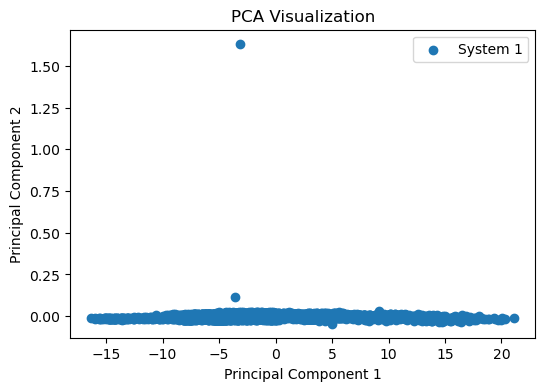

In [13]:
perform_pca_analysis(A1_cal_window, 'System 1 - Sensor A - Cal Window (Amplitude Scaling)')

## Functional PCA

In [14]:
import numpy as np
import pandas as pd
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA

def perform_functional_pca(data_matrix):
    # Convert the data matrix to an FDataGrid object
    fd = FDataGrid(data_matrix=data_matrix, grid_points=data_matrix.columns.astype(float))

    # Apply Functional PCA
    fpca = FPCA(n_components=2)
    fpca.fit(fd)
    pc_scores = fpca.transform(fd)

    # Explain variance ratio
    print('Explain variance PC1 (%): ', fpca.explained_variance_ratio_[0] * 100)
    print('Explain variance PC2 (%): ', fpca.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components = fpca.components_

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component
    pc_scores_df = pd.DataFrame(pc_scores, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[f'TimeSeries_{data_matrix.index[i]}' for i in range(data_matrix.shape[0])])
    print("PC Scores:\n", pc_scores_df)

    # Identify which time series (functional data object) contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pc_scores[:, 0]))  # Index of the maximum absolute score in the first PC
    max_contribution_index_pc2 = np.argmax(np.abs(pc_scores[:, 1]))  # Index of the maximum absolute score in the second PC

    print(f'The time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data_matrix.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data_matrix.index[max_contribution_index_pc2]}')

    # --- PCA visualization ---
    fpca.components_.plot()
    plt.legend(['Component 1', 'Component 2'])
    #plt.figure(figsize=(4, 4))
    plt.show()
    fpca.components_[0].plot()
    plt.legend(['Component 1'])
    plt.show()
    fpca.components_[1].plot()
    plt.legend(['Component 2'])
    plt.show()
    #return [data_matrix.index[max_contribution_index_pc1], data_matrix.index[max_contribution_index_pc1]]

/var/folders/_c/wdm33bq11dvflh73ffxrd8z40000gn/T/ipykernel_24076/2400498744.py:4: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


FPCA CALIBRATION WINDOW

A1_cal_window
Explain variance PC1 (%):  99.99567196489804
Explain variance PC2 (%):  0.002626520329405898
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414199 -453.805639   -0.503728
TimeSeries_12414200 -512.205300   -0.563279
TimeSeries_12414201 -432.155501   -0.219289
TimeSeries_12414202 -528.231688   -0.487444
TimeSeries_12414203 -513.251423   -0.434546
...                         ...         ...
TimeSeries_12537663 -208.425836    0.763367
TimeSeries_12539049  -34.940333    0.279530
TimeSeries_12572832  479.966694   -0.565967
TimeSeries_12572836 -104.794411    0.042022
TimeSeries_12622570  903.848876   -0.823827

[3373 rows x 2 columns]
The time series contributing most to PC1 is at index 2705 with TestID 12573667
The time series contributing most to PC2 is at index 1032 with TestID 12515535


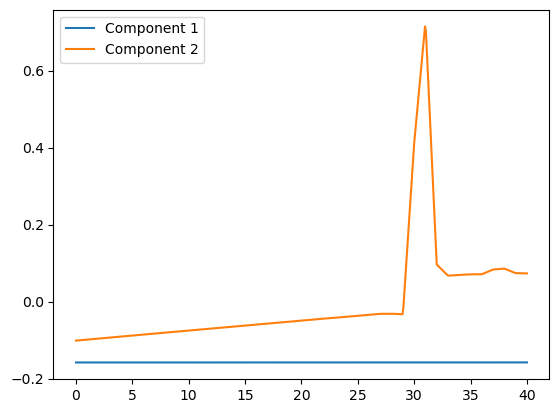

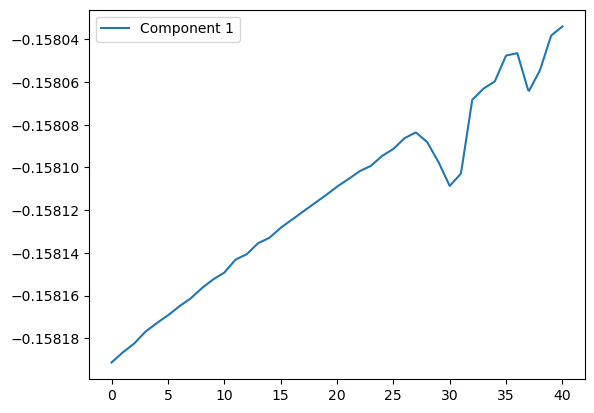

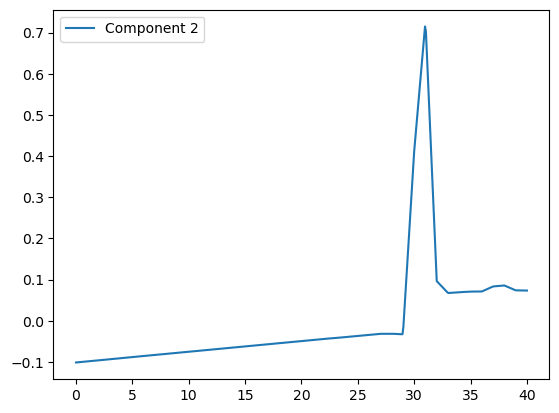

A2_cal_window
Explain variance PC1 (%):  99.99896976213387
Explain variance PC2 (%):  0.0010286411953447044
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -236.298195    0.952859
TimeSeries_3551012 -160.563148    1.061284
TimeSeries_3551031 -318.934671    1.482526
TimeSeries_3551047 -241.728168    0.929098
TimeSeries_3551065 -226.486960    1.093660
...                        ...         ...
TimeSeries_3518461  -32.819407    1.136390
TimeSeries_3518462  136.230237    1.718633
TimeSeries_3518621  173.829863    1.348938
TimeSeries_3518680 -420.488857    1.614163
TimeSeries_3518682  -90.584223    1.879701

[7591 rows x 2 columns]
The time series contributing most to PC1 is at index 5402 with TestID 3556087
The time series contributing most to PC2 is at index 6895 with TestID 3567819


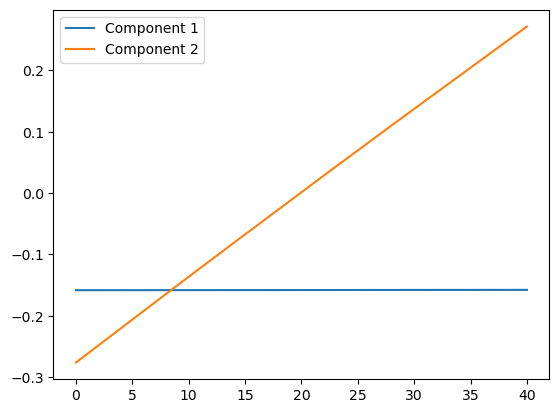

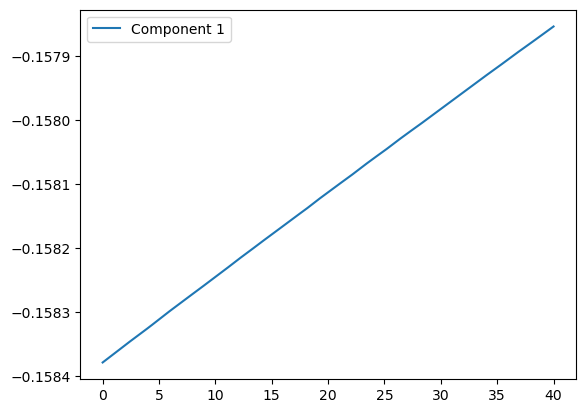

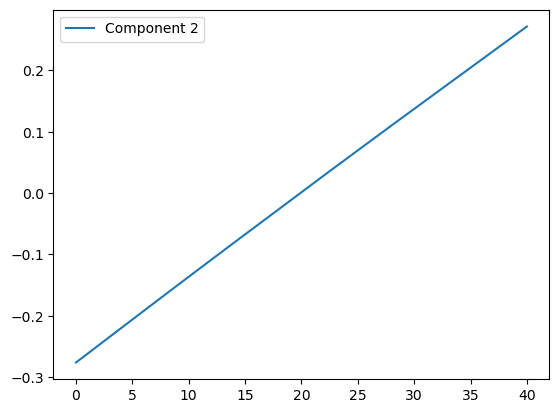

A1_blood_cal_window
Explain variance PC1 (%):  99.99458738018002
Explain variance PC2 (%):  0.004556901867955932
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414199 -408.127103   -0.383163
TimeSeries_12414200 -466.526778   -0.432191
TimeSeries_12414201 -386.476876   -0.148198
TimeSeries_12414202 -482.553147   -0.365244
TimeSeries_12414203 -467.572873   -0.317641
...                         ...         ...
TimeSeries_12624891  -77.505320    0.099772
TimeSeries_12624893 -110.810022    0.084889
TimeSeries_12537663 -162.746915    0.661334
TimeSeries_12572832  525.645189   -0.484945
TimeSeries_12572836  -59.115709    0.050066

[1925 rows x 2 columns]
The time series contributing most to PC1 is at index 1812 with TestID 12572826
The time series contributing most to PC2 is at index 717 with TestID 12515535


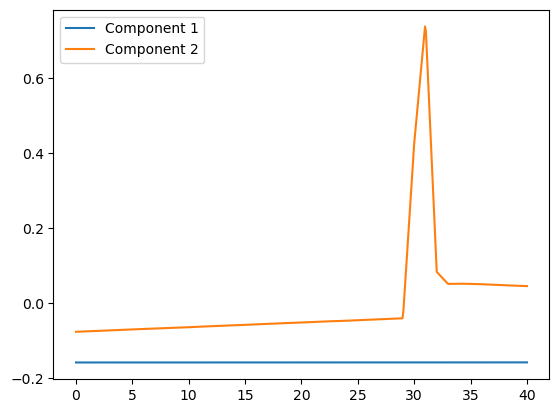

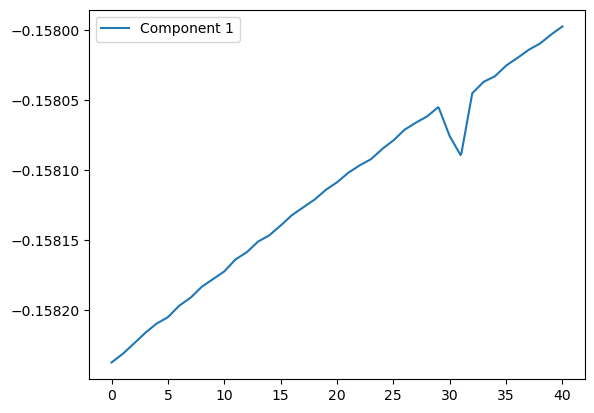

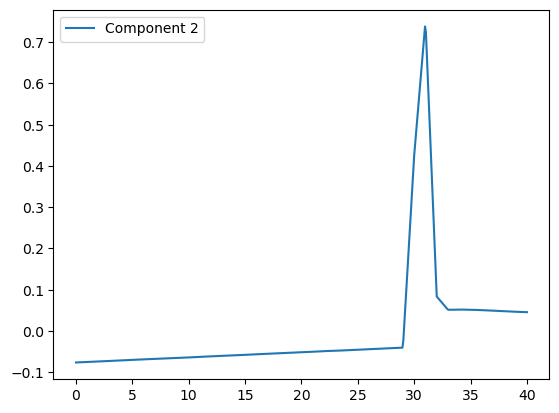

A2_blood_cal_window
Explain variance PC1 (%):  99.99891092142803
Explain variance PC2 (%):  0.0010874547238803995
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -208.832754   -1.068208
TimeSeries_3551012 -133.097703   -1.173998
TimeSeries_3551031 -291.469212   -1.600736
TimeSeries_3551047 -214.262728   -1.044630
TimeSeries_3551065 -199.021514   -1.208663
...                        ...         ...
TimeSeries_3518459 -423.222053   -0.588189
TimeSeries_3518460 -449.038667   -1.728465
TimeSeries_3518431  -95.469798   -1.572110
TimeSeries_3518461   -5.353960   -1.244672
TimeSeries_3518462  163.695705   -1.821051

[4765 rows x 2 columns]
The time series contributing most to PC1 is at index 3657 with TestID 3556087
The time series contributing most to PC2 is at index 3107 with TestID 3561214


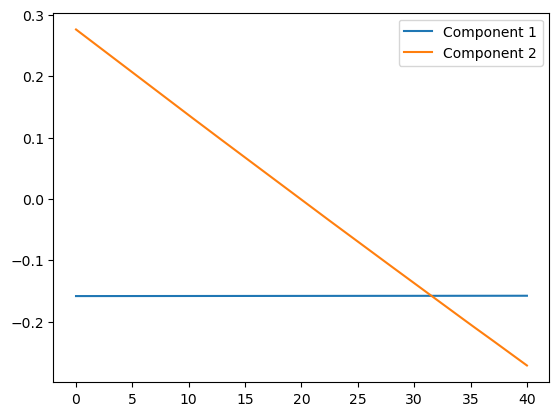

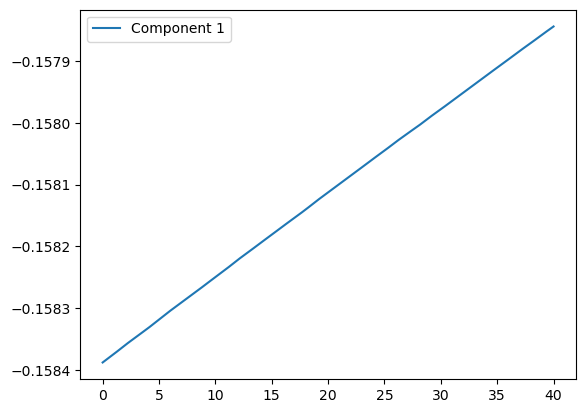

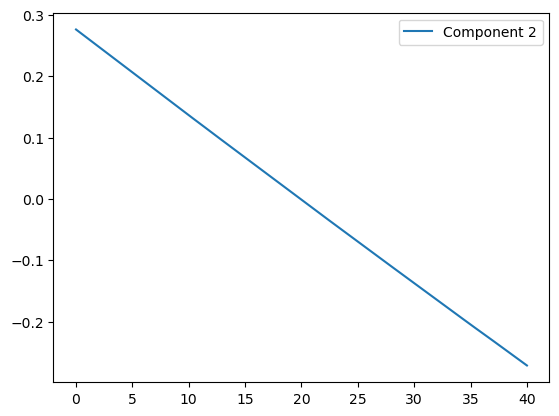

A1_aquous_cal_window
Explain variance PC1 (%):  99.99689271582835
Explain variance PC2 (%):  0.0014547492821491979
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372 -629.509781   -0.732742
TimeSeries_12414373 -595.076387   -0.765346
TimeSeries_12414374 -620.727760   -0.796217
TimeSeries_12414375 -595.944437   -0.739001
TimeSeries_12414377 -647.364524   -0.969456
...                         ...         ...
TimeSeries_12470355  438.723425   -0.706372
TimeSeries_12470361  543.570198   -0.653362
TimeSeries_12470365  -16.495750    0.405912
TimeSeries_12539049  -95.666600    0.242412
TimeSeries_12622570  843.123246   -0.925927

[1448 rows x 2 columns]
The time series contributing most to PC1 is at index 1056 with TestID 12573667
The time series contributing most to PC2 is at index 877 with TestID 12390613


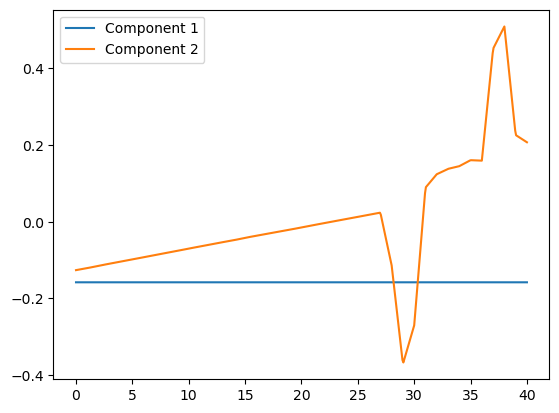

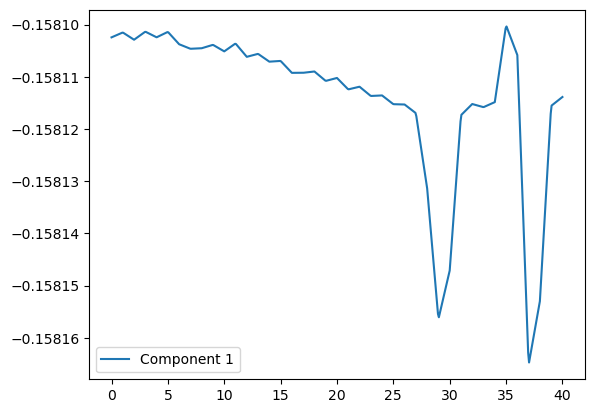

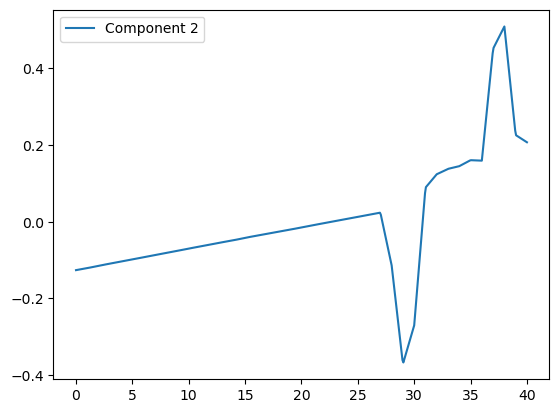

A2_aquous_cal_window
Explain variance PC1 (%):  99.9990700537171
Explain variance PC2 (%):  0.0009283603692952032
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083 -667.039325   -0.627048
TimeSeries_3545084 -620.067234   -0.680688
TimeSeries_3545085 -509.338051   -0.960554
TimeSeries_3545086 -580.034193   -0.607421
TimeSeries_3545087 -538.913792   -0.627943
...                        ...         ...
TimeSeries_3518708 -523.329478    0.688479
TimeSeries_3518710  -15.656537    2.109495
TimeSeries_3518621  127.519491    1.184229
TimeSeries_3518680 -466.799259    1.367630
TimeSeries_3518682 -136.894664    1.678584

[2826 rows x 2 columns]
The time series contributing most to PC1 is at index 2144 with TestID 3572300
The time series contributing most to PC2 is at index 2436 with TestID 3567819


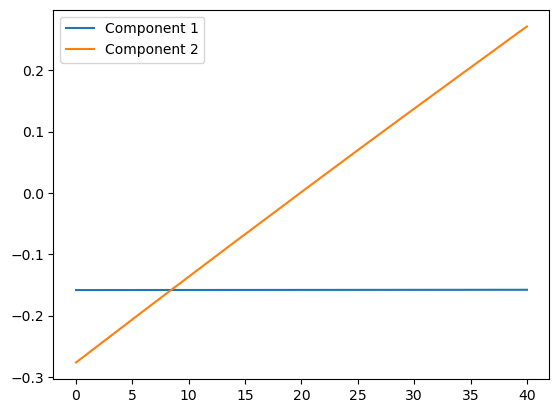

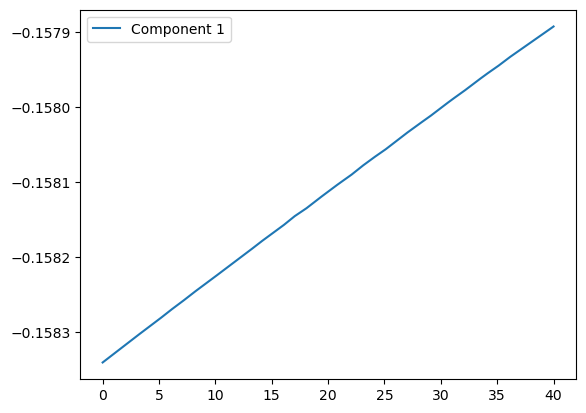

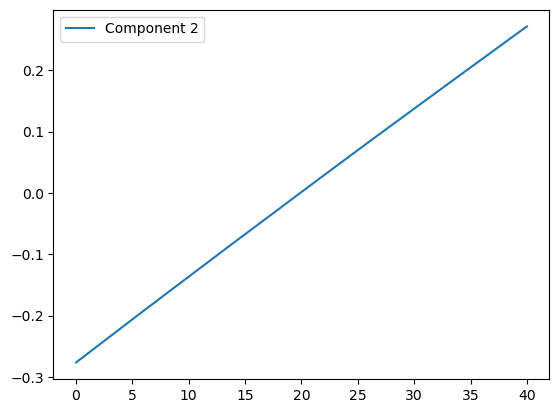

B1_blood_cal_window
Explain variance PC1 (%):  99.99421196572224
Explain variance PC2 (%):  0.005697076229827555
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414199 -275.148413    4.875887
TimeSeries_12414200 -280.805802    3.607139
TimeSeries_12414201 -273.295101    3.941630
TimeSeries_12414202 -290.222632    3.598832
TimeSeries_12414203 -307.853862    3.310592
...                         ...         ...
TimeSeries_12537664 -246.419028    2.045404
TimeSeries_12537668 -172.098024    0.154387
TimeSeries_12624891  119.058892   -2.293450
TimeSeries_12624893   39.771753   -2.583215
TimeSeries_12537663 -137.259856    0.326828

[1953 rows x 2 columns]
The time series contributing most to PC1 is at index 220 with TestID 12544066
The time series contributing most to PC2 is at index 1689 with TestID 12395731


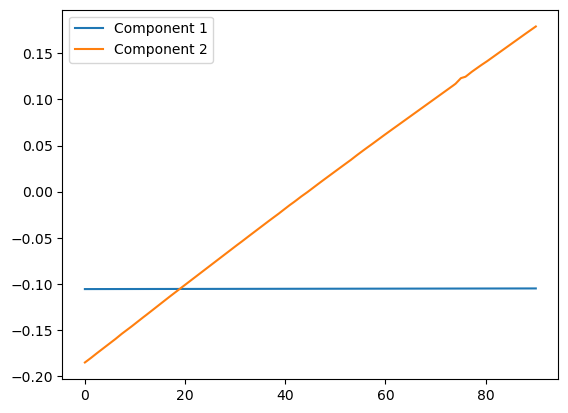

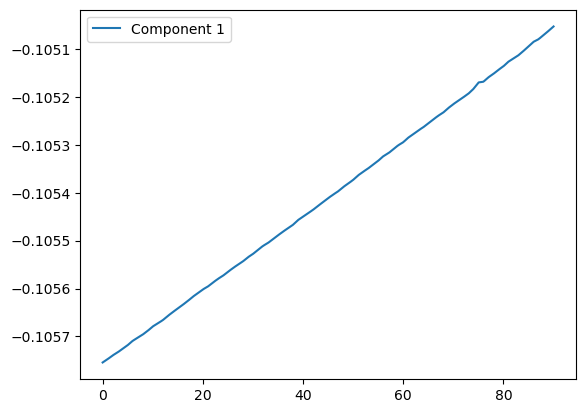

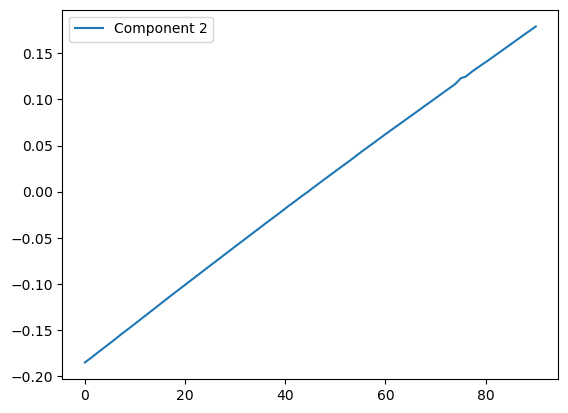

B2_blood_cal_window
Explain variance PC1 (%):  99.99544468454158
Explain variance PC2 (%):  0.004536667529289094
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995  108.833161    0.455469
TimeSeries_3551012   11.282964   -0.882387
TimeSeries_3551031  316.661488   -0.178898
TimeSeries_3551047  190.372878    1.075242
TimeSeries_3551065  105.421154    0.513060
...                        ...         ...
TimeSeries_3518442  586.661104   -5.789548
TimeSeries_3518443  332.729568   -6.787831
TimeSeries_3518444  423.960167   -6.962722
TimeSeries_3518445  255.594984   -6.849608
TimeSeries_3518456  635.697885   -5.829244

[4905 rows x 2 columns]
The time series contributing most to PC1 is at index 418 with TestID 3556268
The time series contributing most to PC2 is at index 2535 with TestID 3567091


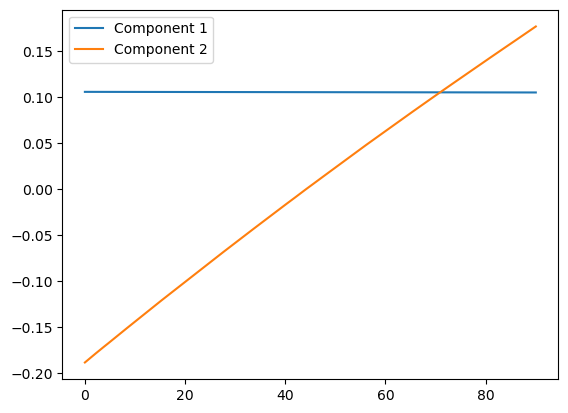

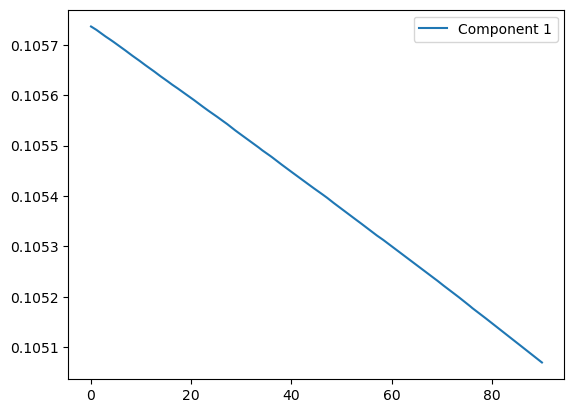

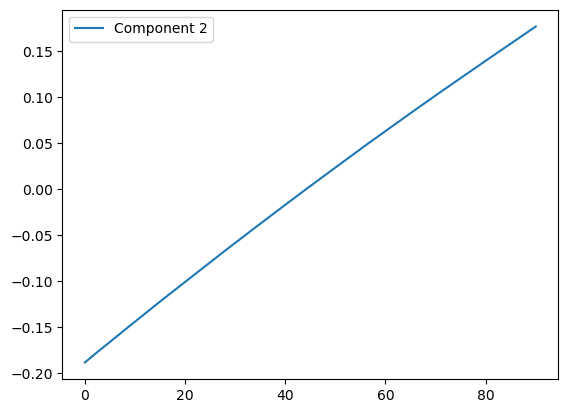

B1_aquous_cal_window
Explain variance PC1 (%):  99.95004718900844
Explain variance PC2 (%):  0.040620436694758115
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372  370.087836    0.756056
TimeSeries_12414373  373.022262    0.713471
TimeSeries_12414374  407.206712    0.837229
TimeSeries_12414375  404.584639    0.778464
TimeSeries_12414377  365.091911    0.626749
...                         ...         ...
TimeSeries_12470355 -118.303757   -1.191698
TimeSeries_12470361   59.681111   -0.596999
TimeSeries_12470365  125.043902   -0.395611
TimeSeries_12539049  128.640851   -0.487266
TimeSeries_12622570   -8.167064   -0.689738

[1444 rows x 2 columns]
The time series contributing most to PC1 is at index 478 with TestID 12437598
The time series contributing most to PC2 is at index 486 with TestID 12530199


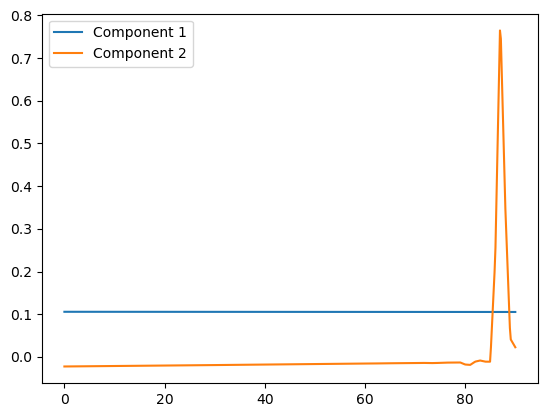

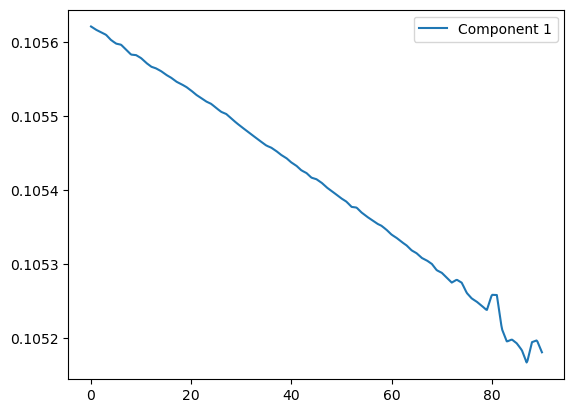

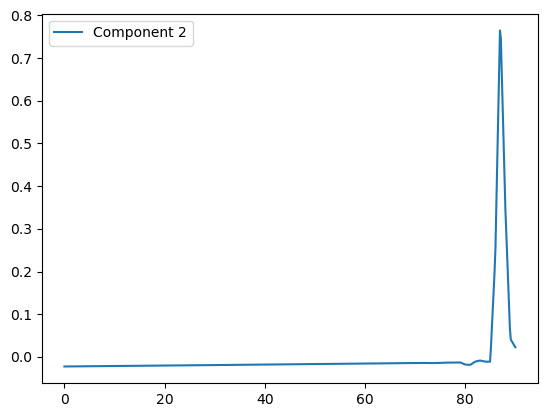

B2_aquous_cal_window
Explain variance PC1 (%):  99.99370052079132
Explain variance PC2 (%):  0.006278919725208689
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083  542.963713    3.560555
TimeSeries_3545084  532.053295    3.204126
TimeSeries_3545085  458.890090    2.283664
TimeSeries_3545086  545.186373    3.804892
TimeSeries_3545087  456.007537    3.332630
...                        ...         ...
TimeSeries_3518583  579.389070   -6.455076
TimeSeries_3518675  603.868200   -6.078152
TimeSeries_3518676  426.026943   -5.929796
TimeSeries_3518677  413.288253   -7.134465
TimeSeries_3518678  312.100772   -7.115318

[2869 rows x 2 columns]
The time series contributing most to PC1 is at index 195 with TestID 3548448
The time series contributing most to PC2 is at index 2437 with TestID 3567819


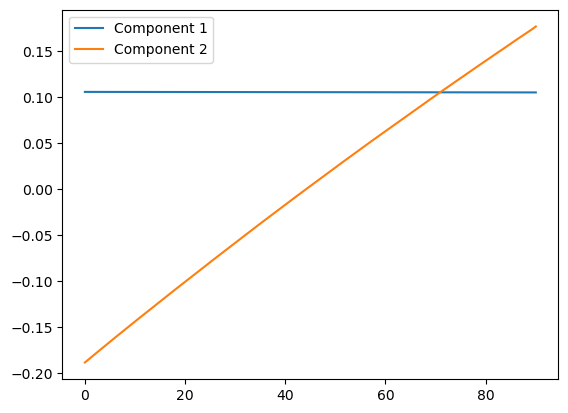

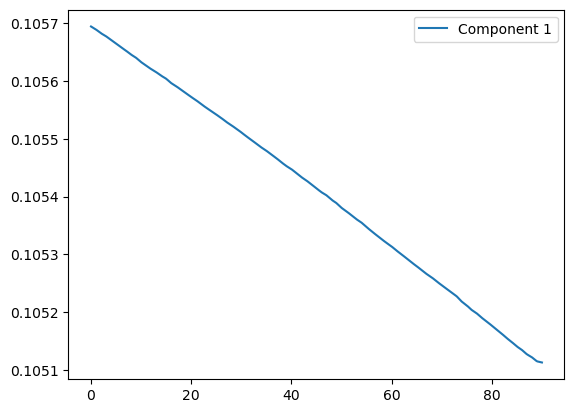

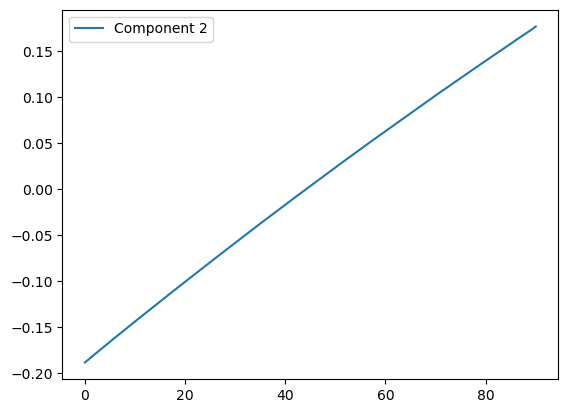

In [15]:
print("FPCA CALIBRATION WINDOW\n")
print("A1_cal_window")
perform_functional_pca(A1_cal_window)
print("A2_cal_window")
perform_functional_pca(A2_cal_window)
print("A1_blood_cal_window")
perform_functional_pca(A1_blood_cal_window)
print("A2_blood_cal_window")
perform_functional_pca(A2_blood_cal_window)
print("A1_aquous_cal_window")
perform_functional_pca(A1_aquous_cal_window)
print("A2_aquous_cal_window")
perform_functional_pca(A2_aquous_cal_window)
print("B1_blood_cal_window")
perform_functional_pca(B1_blood_cal_window)
print("B2_blood_cal_window")
perform_functional_pca(B2_blood_cal_window)
print("B1_aquous_cal_window")
perform_functional_pca(B1_aquous_cal_window)
print("B2_aquous_cal_window")
perform_functional_pca(B2_aquous_cal_window)

FPCA SAMPLE WINDOW

A1_sample_window
Explain variance PC1 (%):  99.99942957270176
Explain variance PC2 (%):  0.0004800535264657234
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414199 -318.758739    0.208316
TimeSeries_12414200 -364.783379    0.266692
TimeSeries_12414201 -306.076729   -0.003615
TimeSeries_12414202 -378.663800    0.258178
TimeSeries_12414203 -366.976216    0.222363
...                         ...         ...
TimeSeries_12537663 -244.779030   -0.378768
TimeSeries_12539049  -40.453352   -0.299050
TimeSeries_12572832  310.868257    0.278849
TimeSeries_12572836 -156.369440    0.165944
TimeSeries_12622570  713.523382    0.520448

[3373 rows x 2 columns]
The time series contributing most to PC1 is at index 2841 with TestID 12574513
The time series contributing most to PC2 is at index 2618 with TestID 12371902


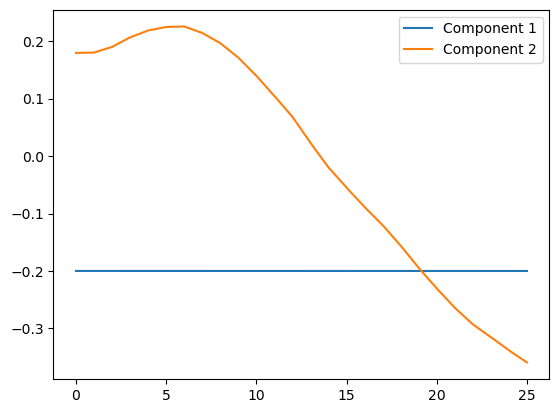

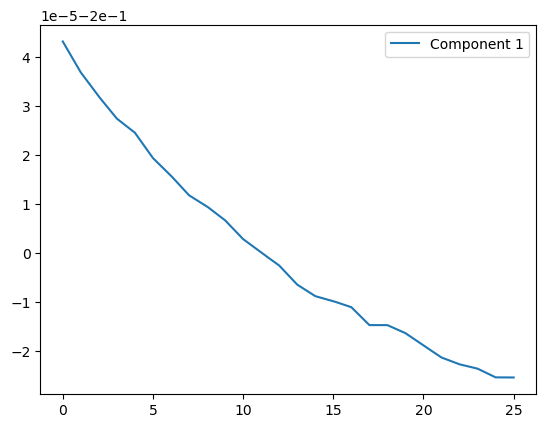

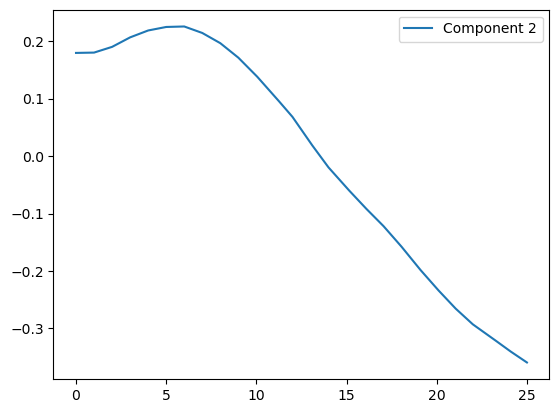

A2_sample_window
Explain variance PC1 (%):  99.99965107061422
Explain variance PC2 (%):  0.0003472340189545281
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -221.085937    0.358876
TimeSeries_3551012 -162.481360    0.388537
TimeSeries_3551031 -290.828647    0.635327
TimeSeries_3551047 -225.455717    0.379081
TimeSeries_3551065 -214.887227    0.445435
...                        ...         ...
TimeSeries_3518461   37.079400    0.404007
TimeSeries_3518462  165.505316    0.328739
TimeSeries_3518621  111.853299    0.609070
TimeSeries_3518680 -358.949330    0.839964
TimeSeries_3518682  -99.125298    0.880211

[7569 rows x 2 columns]
The time series contributing most to PC1 is at index 5380 with TestID 3556087
The time series contributing most to PC2 is at index 3895 with TestID 3569098


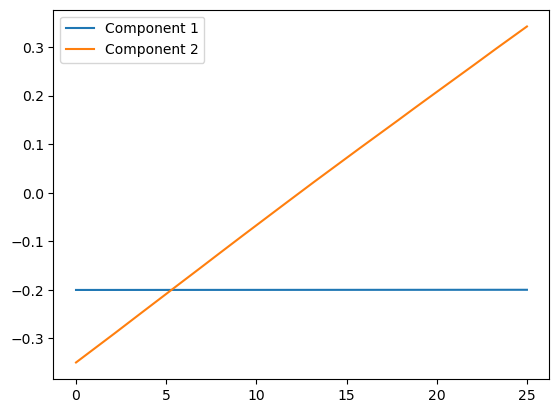

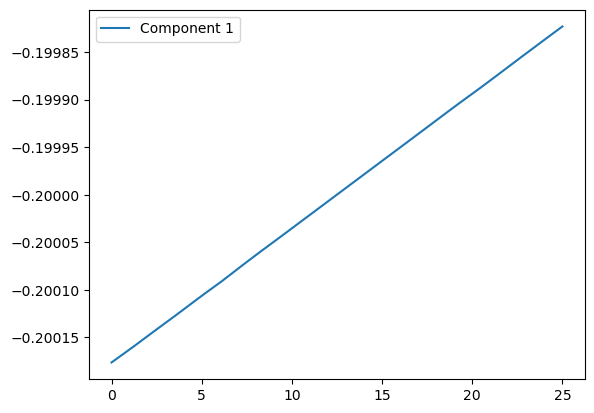

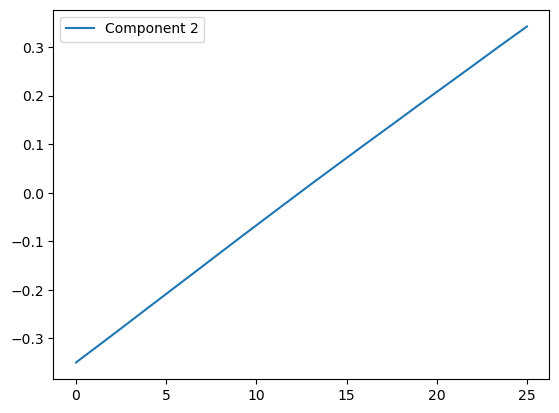

A1_blood_sample_window
Explain variance PC1 (%):  99.99924404984762
Explain variance PC2 (%):  0.0006274621771418517
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414199 -289.085240    0.127575
TimeSeries_12414200 -335.109880    0.182540
TimeSeries_12414201 -276.403228   -0.070676
TimeSeries_12414202 -348.990301    0.177243
TimeSeries_12414203 -337.302716    0.142291
...                         ...         ...
TimeSeries_12624891   -1.794142   -0.128294
TimeSeries_12624893  -23.946058   -0.172566
TimeSeries_12537663 -215.105528   -0.427893
TimeSeries_12572832  340.541756    0.197004
TimeSeries_12572836 -126.695940    0.086903

[1925 rows x 2 columns]
The time series contributing most to PC1 is at index 1715 with TestID 12574513
The time series contributing most to PC2 is at index 1599 with TestID 12371902


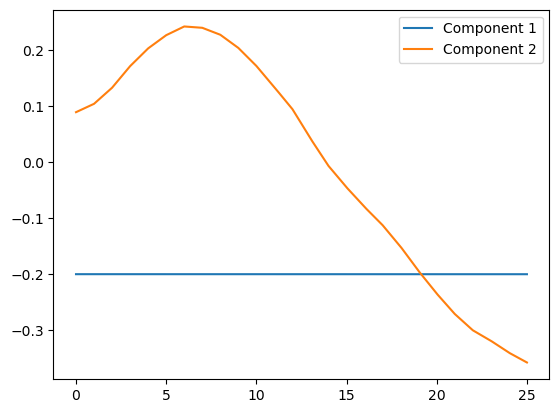

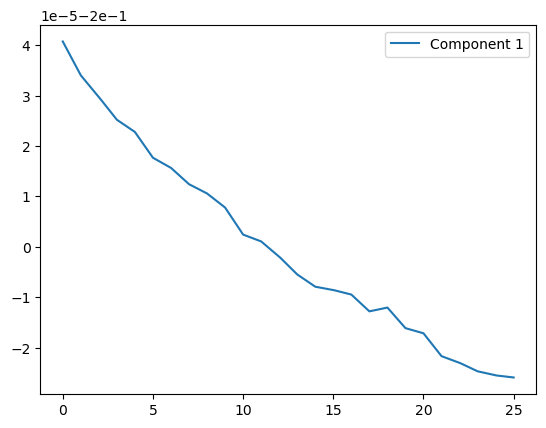

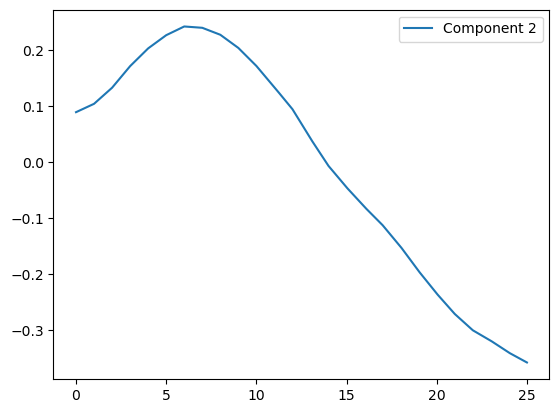

A2_blood_sample_window
Explain variance PC1 (%):  99.99965421194896
Explain variance PC2 (%):  0.0003438582171950513
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -210.130097   -0.415244
TimeSeries_3551012 -151.525521   -0.447376
TimeSeries_3551031 -279.872818   -0.688715
TimeSeries_3551047 -214.499878   -0.435252
TimeSeries_3551065 -203.931391   -0.502051
...                        ...         ...
TimeSeries_3518459 -276.122748   -0.099831
TimeSeries_3518460 -305.112886   -0.592062
TimeSeries_3518431 -180.087065   -0.679302
TimeSeries_3518461   48.035238   -0.471294
TimeSeries_3518462  176.461156   -0.401583

[4744 rows x 2 columns]
The time series contributing most to PC1 is at index 3636 with TestID 3556087
The time series contributing most to PC2 is at index 3086 with TestID 3561214


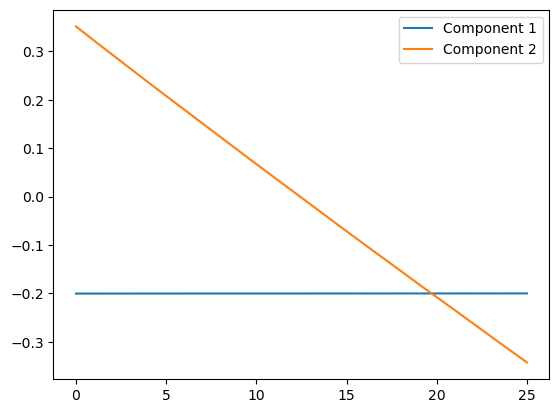

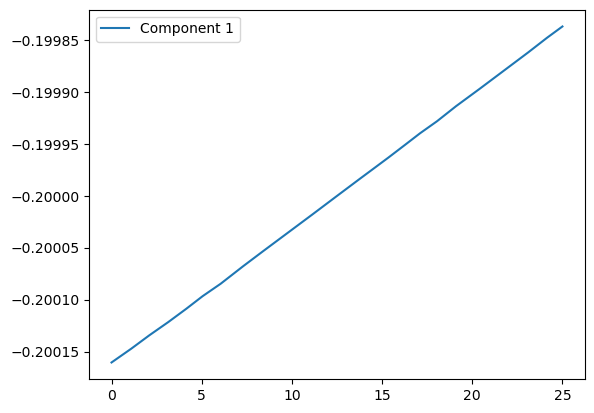

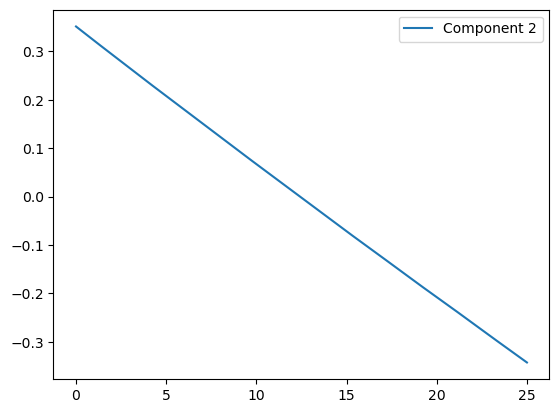

A1_aquous_sample_window
Explain variance PC1 (%):  99.99967124196277
Explain variance PC2 (%):  0.00032498569902832
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372 -489.764557    0.490395
TimeSeries_12414373 -462.329920    0.514806
TimeSeries_12414374 -482.332115    0.497030
TimeSeries_12414375 -462.939683    0.507523
TimeSeries_12414377 -501.175944    0.651095
...                         ...         ...
TimeSeries_12470355  355.014600    0.465229
TimeSeries_12470361  436.403134    0.374374
TimeSeries_12470365  -19.866882   -0.308478
TimeSeries_12539049  -79.901915   -0.207274
TimeSeries_12622570  674.074900    0.578197

[1448 rows x 2 columns]
The time series contributing most to PC1 is at index 1056 with TestID 12573667
The time series contributing most to PC2 is at index 328 with TestID 12597803


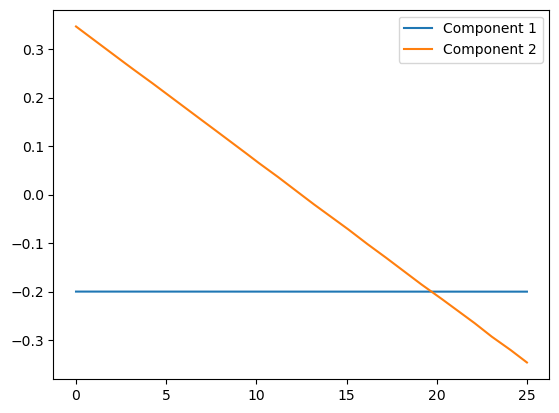

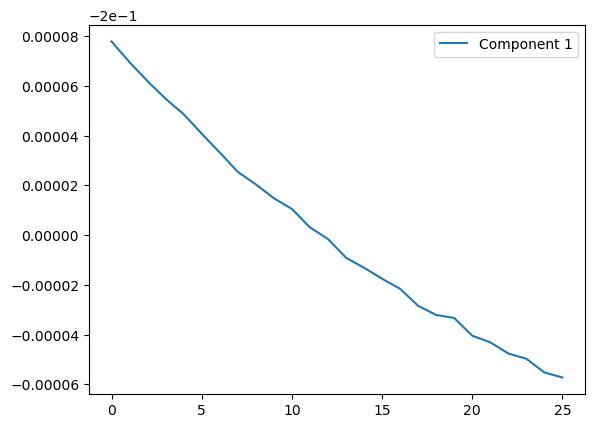

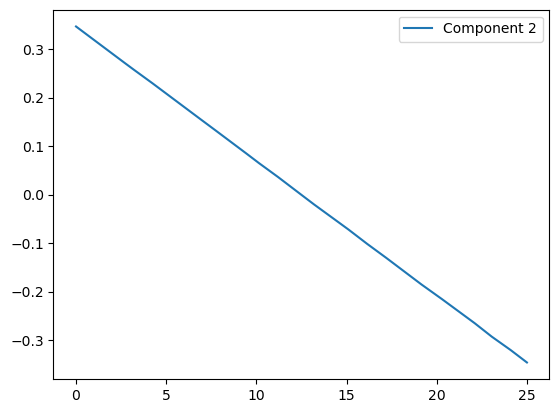

A2_aquous_sample_window
Explain variance PC1 (%):  99.99966477125272
Explain variance PC2 (%):  0.0003338750997013666
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083 -516.005402   -0.399182
TimeSeries_3545084 -479.051373   -0.380730
TimeSeries_3545085 -389.931613   -0.538065
TimeSeries_3545086 -447.784193   -0.373887
TimeSeries_3545087 -415.255898   -0.423228
...                        ...         ...
TimeSeries_3518708 -414.872714    0.296657
TimeSeries_3518710  -25.614381    0.722005
TimeSeries_3518621   93.455229    0.496746
TimeSeries_3518680 -377.347394    0.741141
TimeSeries_3518682 -117.523360    0.773916

[2825 rows x 2 columns]
The time series contributing most to PC1 is at index 2143 with TestID 3572300
The time series contributing most to PC2 is at index 992 with TestID 3569098


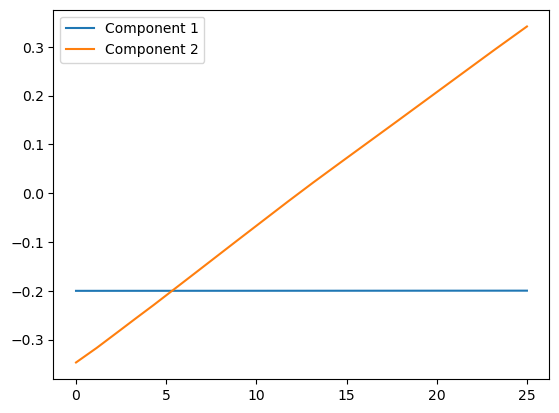

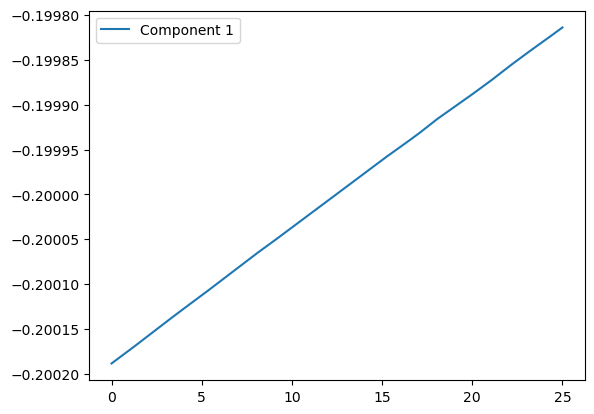

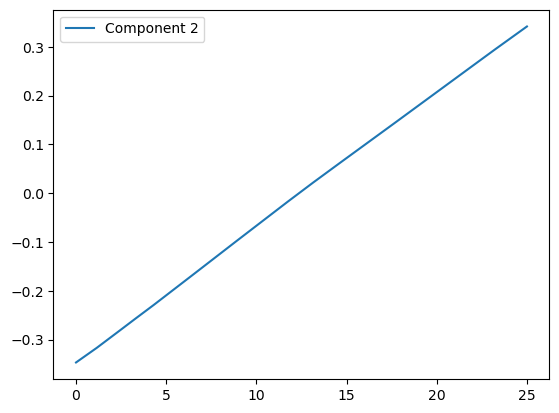

B1_blood_sample_window
Explain variance PC1 (%):  99.99615096537379
Explain variance PC2 (%):  0.003831702821538823
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414199 -111.967146   -0.099707
TimeSeries_12414200 -112.055364   -0.146924
TimeSeries_12414201 -110.468278   -0.018205
TimeSeries_12414202 -115.376753   -0.059472
TimeSeries_12414203 -122.685798    0.032979
...                         ...         ...
TimeSeries_12537664 -227.036111   -0.078348
TimeSeries_12537668 -188.071046   -0.204658
TimeSeries_12624891  187.350188    1.236780
TimeSeries_12624893  163.277313    1.790128
TimeSeries_12537663 -172.952310   -0.213984

[1953 rows x 2 columns]
The time series contributing most to PC1 is at index 241 with TestID 12546591
The time series contributing most to PC2 is at index 1285 with TestID 12472338


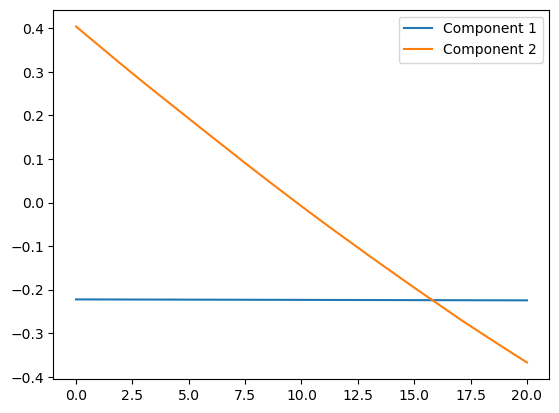

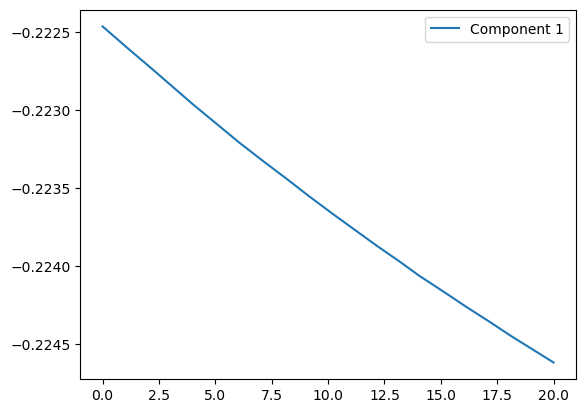

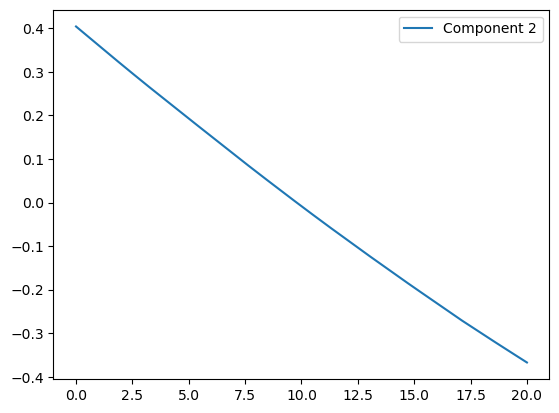

B2_blood_sample_window
Explain variance PC1 (%):  99.9979481002147
Explain variance PC2 (%):  0.002047577770285789
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995  125.828862   -0.521513
TimeSeries_3551012   75.769389   -0.457067
TimeSeries_3551031  217.339586   -0.288116
TimeSeries_3551047  162.748665   -0.420728
TimeSeries_3551065  123.748125   -0.466760
...                        ...         ...
TimeSeries_3518442  129.338492    2.974526
TimeSeries_3518443    8.644930    2.767316
TimeSeries_3518444   51.613942    2.839762
TimeSeries_3518445  -31.047166    3.159832
TimeSeries_3518456  152.342691    2.869557

[4911 rows x 2 columns]
The time series contributing most to PC1 is at index 418 with TestID 3556268
The time series contributing most to PC2 is at index 4886 with TestID 3518458


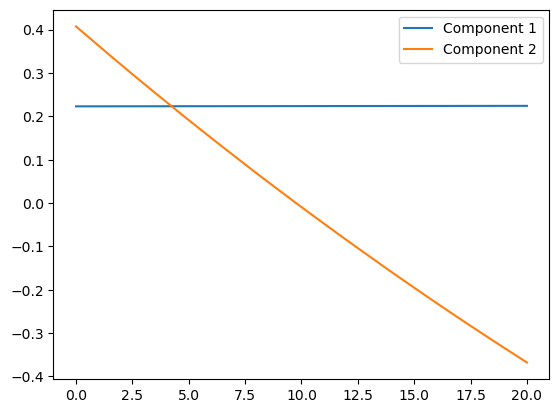

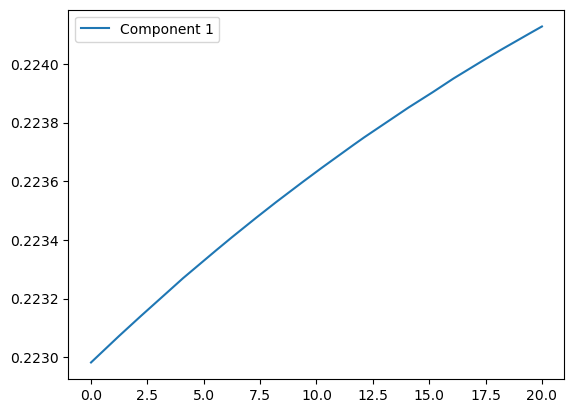

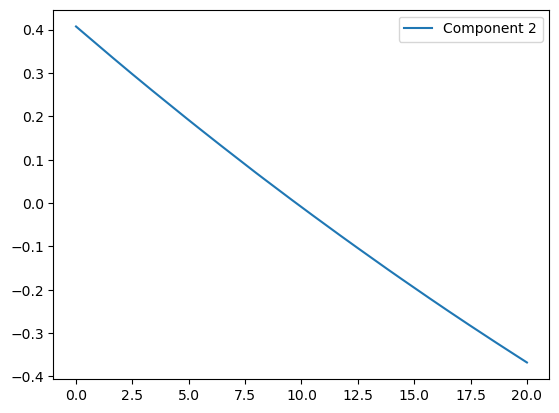

B1_aquous_sample_window
Explain variance PC1 (%):  99.99969435313211
Explain variance PC2 (%):  0.0002945649022133371
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372  182.628535   -0.371452
TimeSeries_12414373  181.915975   -0.357506
TimeSeries_12414374  199.670051   -0.371402
TimeSeries_12414375  198.345148   -0.349007
TimeSeries_12414377  177.536221   -0.308582
...                         ...         ...
TimeSeries_12470355  -71.293703    0.351091
TimeSeries_12470361   17.260059    0.141058
TimeSeries_12470365   46.855490    0.186119
TimeSeries_12539049   45.071983    0.079004
TimeSeries_12622570  -25.500877    0.127803

[1444 rows x 2 columns]
The time series contributing most to PC1 is at index 478 with TestID 12437598
The time series contributing most to PC2 is at index 1056 with TestID 12623840


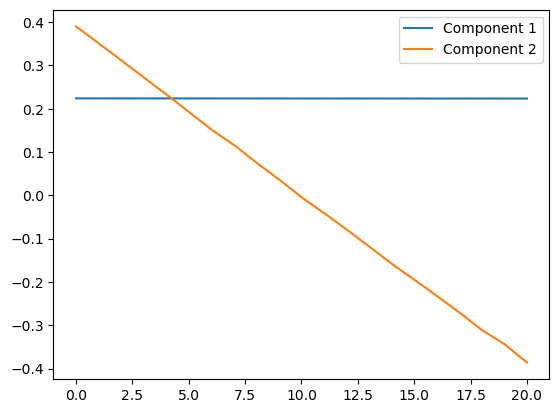

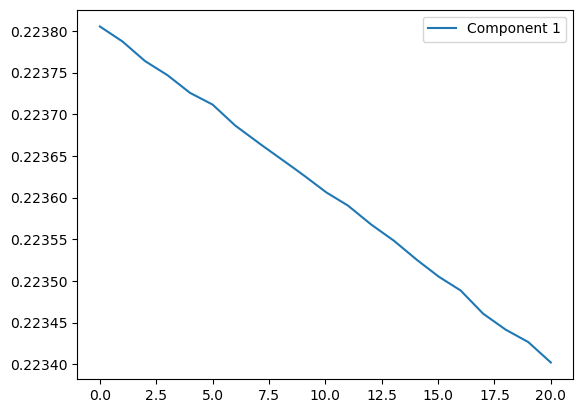

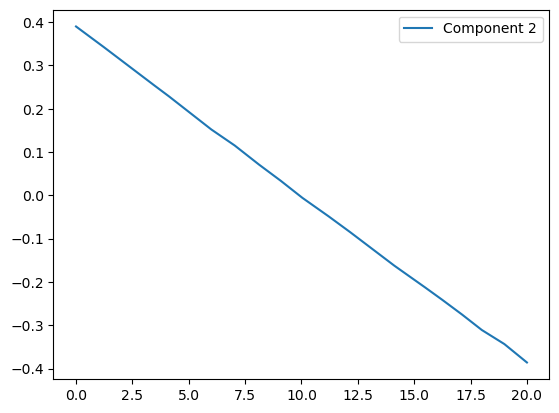

B2_aquous_sample_window
Explain variance PC1 (%):  99.99974196407967
Explain variance PC2 (%):  0.00023642539784743402
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083  262.283016   -0.306035
TimeSeries_3545084  255.218496   -0.312839
TimeSeries_3545085  217.920958   -0.155114
TimeSeries_3545086  261.642030   -0.298189
TimeSeries_3545087  220.639232   -0.280526
...                        ...         ...
TimeSeries_3518583  244.831386    0.481803
TimeSeries_3518675  235.042841    0.494424
TimeSeries_3518676  153.773558    0.528269
TimeSeries_3518677  142.064878    0.682571
TimeSeries_3518678   96.752257    0.676269

[2869 rows x 2 columns]
The time series contributing most to PC1 is at index 213 with TestID 3548492
The time series contributing most to PC2 is at index 2839 with TestID 3518631


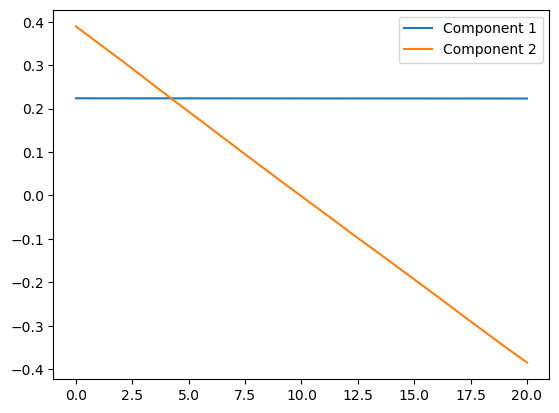

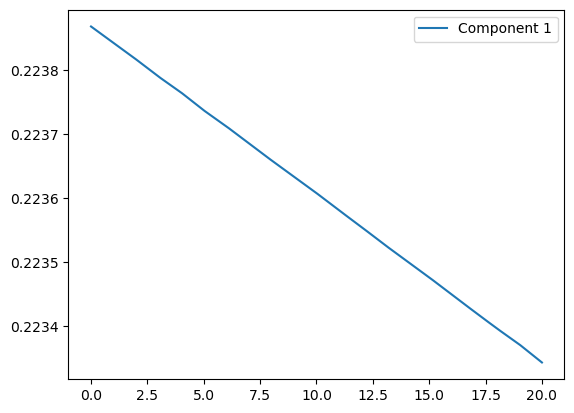

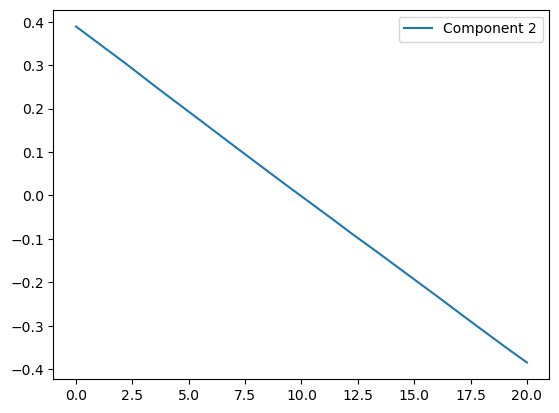

In [16]:
print("FPCA SAMPLE WINDOW\n")
print("A1_sample_window")
perform_functional_pca(A1_sample_window)
print("A2_sample_window")
perform_functional_pca(A2_sample_window)
print("A1_blood_sample_window")
perform_functional_pca(A1_blood_sample_window)
print("A2_blood_sample_window")
perform_functional_pca(A2_blood_sample_window)
print("A1_aquous_sample_window")
perform_functional_pca(A1_aquous_sample_window)
print("A2_aquous_sample_window")
perform_functional_pca(A2_aquous_sample_window)
print("B1_blood_sample_window")
perform_functional_pca(B1_blood_sample_window)
print("B2_blood_sample_window")
perform_functional_pca(B2_blood_sample_window)
print("B1_aquous_sample_window")
perform_functional_pca(B1_aquous_sample_window)
print("B2_aquous_sample_window")
perform_functional_pca(B2_aquous_sample_window)

## Verifying waveforms which contributes the most to PC's shape

In [17]:
# PC2 major contributor
A1_Merged[A1_Merged['TestID'] == 12515535].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode
1051,Eurotrol L1,2024-02-23 15:05:03,07-24030-00,6489,24,1732,200.2,196.4,System 1,Sensor A,29.6478,NaN,EarlyInjection,CalDriftQCHigh,EarlyInjection,NaN,NaN


In [18]:
# PC2 major contributor
A1_Merged[A1_Merged['TestID'] == 12371902].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode
2652,Eurotrol L1,2024-01-03 12:28:54,07-23158-00,7307,210,6728,188.6,187.8,System 1,Sensor A,21.4352,NaN,SampleFailedQC,EarlyDipInSample,SampleFailedQC,NaN,NaN


In [19]:
A1_Merged[A1_Merged['TestID'] == 12515535].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode
1051,Eurotrol L1,2024-02-23 15:05:03,07-24030-00,6489,24,1732,200.2,196.4,System 1,Sensor A,29.6478,NaN,EarlyInjection,CalDriftQCHigh,EarlyInjection,NaN,NaN


In [20]:
A1_Merged[A1_Merged['TestID'] == 12390613].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode
2374,TB11,2024-01-09 17:39:11,07-23228-00,674,146,611,189.2,185.4,System 1,Sensor A,21.9974,NaN,EarlyInjection,CalNoiseQCHigh,EarlyInjection,NaN,NaN


In [21]:
A2_Merged[A2_Merged['TestID'] == 3561214].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode
4428,Eurotrol L3,2024-03-11 14:39:38,16-23347-40,301133,89,48,187.0,185.4,System 2A,Sensor A,23.2209,NaN,NaN,Success,NoError,NoError,Success


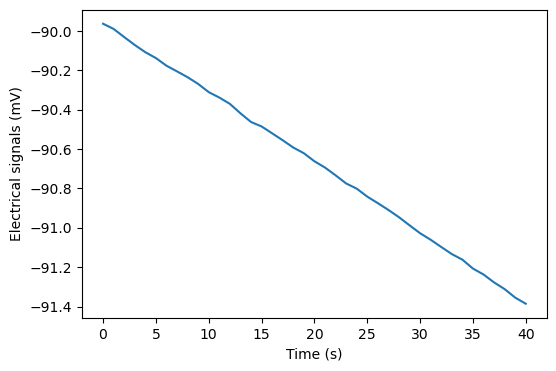

In [22]:
A2_cal_window[A2_cal_window.index == 3561214]
plot_all_time_series(A2_cal_window[A2_cal_window.index == 3561214])